In [1]:
library(Biostrings)
library(data.table)
library(ggplot2)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The

In [2]:
library(BSgenome.Mmusculus.UCSC.mm10)

Loading required package: BSgenome

Loading required package: GenomeInfoDb

Loading required package: GenomicRanges

Loading required package: rtracklayer

Warning message:
“replacing previous import ‘BiocGenerics::dims’ by ‘Biobase::dims’ when loading ‘SummarizedExperiment’”
Warning message:
“multiple methods tables found for ‘type’”
Warning message:
“multiple methods tables found for ‘lengths’”
Warning message:
“multiple methods tables found for ‘rowSums’”
Warning message:
“multiple methods tables found for ‘colSums’”
Warning message:
“multiple methods tables found for ‘rowMeans’”
Warning message:
“multiple methods tables found for ‘colMeans’”
Warning message:
“multiple methods tables found for ‘splitAsList’”
Warning message:
“replacing previous import ‘BiocGenerics::type’ by ‘DelayedArray::type’ when loading ‘SummarizedExperiment’”
Warning message:
“replacing previous import ‘BiocGenerics::type’ by ‘Biostrings::type’ when loading ‘GenomicAlignments’”
Warning message:
“no function fo

In [3]:
output_dir <- "/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest/"

In [4]:
dir.create(output_dir)

Warning message in dir.create(output_dir):
“cannot create dir '/scratch/lab_bock/shared/projects/compEpi/validation/insilicoDigest', reason 'No such file or directory'”


In [5]:
theme_set(theme_bw())

In [6]:
get_seq <- function(chr, start, end, genome){
    s <- subseq(genome[[chr]], start, end)
    return(as.character(s))
}

In [117]:
# Identify the MspI recongnition sites for each chromosomal entry
# Generate a dataframe with the length of MspI digested fragments
insilicoRRBS <- function(genome){
    genome_set <- get(genome)
    mdf=data.frame()
    
    uniqFragments=data.table()
    
    ## looking for start positions of RRBS-sp enzymes
    for (pattern_seq in c("CCGG", "TCGA")){
      for (i in seq_along(genome_set)){
              if ("DNAStringSet"%in%is(genome_set[[i]])) {
                        print(length(genome_set[[i]]))
                                                    next}
          
      ##matching the pattern to the genome
      m <- matchPattern(pattern_seq, genome_set[[i]])
      ##getting everything, EXCEPT the pattern      
      frags = gaps(m)
            
      ##extracting geomic coordinates
      starts<-start(frags)
      ends<-end(frags)
      widths<-width(frags)

      ##generating a df and performing coordinate shifts to include that reads to start with CGG/TCG and end with the reverse complement
      temp_df<-data.frame(start=starts-3,end=ends+3,width=widths+6,chr=seqnames(genome_set)[i],genome=genome) #actually end = ends
          
      ##as the first becomes -2 => shifting to 0
      temp_df$start<-replace(temp_df$start, temp_df$start == -2, 0)
      temp_df$name <- pattern_seq
      temp_df<-temp_df[c("genome","chr","start","end","width", "name")]
      mdf<-rbind(mdf,temp_df)
  
      #get coordinates of the start and the end for the generated sequences:
      
      #50 - size-selection(shortest you get via the library prep), but: including the adapters, which we don't account for
      #500 - upper threshold for the width of the fragment we are interested in
      sub=frags[width(frags)>=50]
      
      #fragment ends
      tail_start=width(sub)-49
      tail_end=width(sub)
      tail_end_pos=end(sub)+3
      tail_start_pos=end(sub)-49+3
  
      ##fragment starts
      front_end_pos=start(sub)+49-3
      front_start_pos=start(sub)-3
      
      ##summary dataframe    
      uniqFragments=rbindlist(list(uniqFragments,data.table(genome=genome, pattern = pattern_seq, chr=seqnames(genome_set)[i],
                                                            start=c(front_start_pos,tail_start_pos),
                                                            end=c(front_end_pos,tail_end_pos),
                                                            width=c(width(sub),width(sub)),
                                                            origin=c(rep("front",length(front_start_pos)),rep("tail",length(tail_start_pos))))))
      }
    }
    
    #uniqFragments[,dupl:=duplicated(seq),by=list(genome, pattern)]
    ## adjusting the start of the first fragment to 1:
    uniqFragments[uniqFragments$start <= 0, ]$start <- 1
    
    ##extracting the sequence:
    uniqFragments[, seq_exact :=get_seq(chr, start, end, genome_set), by = 1:nrow(uniqFragments)]
    
    ## we are only interested in the sequences, 
    ##saving output
    output_dir_genome <- paste0(output_dir, genome)
    dir.create(output_dir_genome, exisits_ok=TRUE)
   
    
    ##saving stats of fragment length:
    mdf=as.data.table(mdf)
    print(head(mdf))
    
    count=mdf[,.N,by=c("width","genome", "name")]
    
    ggplot(count[width>50&width<500],aes(x=width,y=N)) + 
                                geom_line() +
                                facet_wrap(~genome,scale="free_y") +
                                    xlab("fragment length") + theme_bw()
    
    ggsave(file.path(output_dir_genome, "fragmentLengths.svg"),width=8,height=5)
    

     #saving Rdata
    save(uniqFragments,file=paste0(output_dir_genome, "/uniqFragments.RData"))
    save(mdf,file=paste0(output_dir_genome, "/fragmentLength.RData"))
    
    return(uniqFragments)

}

In [ ]:
df <- insilicoRRBS("Mmusculus")

In [8]:
unF <- df[[1]] ## insilico generated RRBS reads

In [9]:
mdf <- df[[2]]

In [111]:
unF[unF$start <= 0, ]$start <- 1

In [112]:
head(unF)

genome,pattern,chr,start,end,width,origin,seq,dupl
Mmusculus,CCGG,chr1,1,47,3003896,front,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,FALSE
Mmusculus,CCGG,chr1,3003898,3003947,3528,front,ATGTCTGGAGCCTGAAACAGGGGTATGTCCCAGACACTGTGTAGCTTCTG,FALSE
Mmusculus,CCGG,chr1,3007430,3007479,7177,front,AGTTGAGTGTAACTTTTTCCATCAGTTTTAATACATTAAGCAGCTTATCT,FALSE
Mmusculus,CCGG,chr1,3014611,3014660,359,front,AGACAGCATTAAGGAAGCAGAAAACCAGCCTGACCAGGGTCACAAGTCCC,FALSE
Mmusculus,CCGG,chr1,3014974,3015023,707,front,GGTACTAGTTAGTTCATATTGTTATTCCACCTATAGGGTTGCAGTTCCCA,FALSE
Mmusculus,CCGG,chr1,3015685,3015734,932,front,TTGGGACATCTTCTGGATATATGCAAAGGAGAGGTATTGTGGGATCCTTA,FALSE


In [21]:
head(unF[unF$origin=="tail",])

genome,pattern,chr,start,end,width,origin,seq,dupl
Mmusculus,CCGG,chr1,3003850,3003899,3003896,tail,GGGGGTCAAAGCCCTCCTTGGCAGCCACCTTTTTCAGGCGGAGAAGGTGC,FALSE
Mmusculus,CCGG,chr1,3007382,3007431,3528,tail,GGAGGTTCTAGGATCCATCACTCTAGCCTTTCCTGAGGATTAGGCTTTTC,FALSE
Mmusculus,CCGG,chr1,3014563,3014612,7177,tail,TTAGGACCTCCAGTGGAACACAACTTCTGTTCCAATCTAATCGTGCAAGA,FALSE
Mmusculus,CCGG,chr1,3014926,3014975,359,tail,ATGGCCGACTAGGCCATCTTTTGATACATATGCAGCTAGAGACAAGAGCT,FALSE
Mmusculus,CCGG,chr1,3015637,3015686,707,tail,CTATTATAAACAAGGCTGCTATGAACACAGTGGAGCATGTGTCCTTCTTA,FALSE
Mmusculus,CCGG,chr1,3016573,3016622,932,tail,CCAGTACCATGCAGTTTTGATCACAATTGCTCTGTAGTACAGTTTTAGGT,FALSE


In [63]:
sub <- unF[c(2:5), ]

In [64]:
head(sub)

genome,pattern,chr,start,end,width,origin,seq,dupl
Mmusculus,CCGG,chr1,3003898,3003947,3528,front,ATGTCTGGAGCCTGAAACAGGGGTATGTCCCAGACACTGTGTAGCTTCTG,FALSE
Mmusculus,CCGG,chr1,3007430,3007479,7177,front,AGTTGAGTGTAACTTTTTCCATCAGTTTTAATACATTAAGCAGCTTATCT,FALSE
Mmusculus,CCGG,chr1,3014611,3014660,359,front,AGACAGCATTAAGGAAGCAGAAAACCAGCCTGACCAGGGTCACAAGTCCC,FALSE
Mmusculus,CCGG,chr1,3014974,3015023,707,front,GGTACTAGTTAGTTCATATTGTTATTCCACCTATAGGGTTGCAGTTCCCA,FALSE


In [109]:
subseq(genome[["chr1"]], 1, 3)

  3-letter "DNAString" instance
seq: NNN

In [74]:
get_seq(3015685, 3015734)

[1] 3015685
[1] 3015734


  50-letter "DNAString" instance
seq: CGGTTGGGACATCTTCTGGATATATGCAAAGGAGAGGTATTGTGGGATCC

In [79]:
1:4

[1] 1 2 3 4

In [105]:
unF[, seq_exact :=get_seq(chr, start, end), by = 1:nrow(sub)]

In [106]:
sub

genome,pattern,chr,start,end,width,origin,seq,dupl,seq_exact
Mmusculus,CCGG,chr1,3003898,3003947,3528,front,ATGTCTGGAGCCTGAAACAGGGGTATGTCCCAGACACTGTGTAGCTTCTG,FALSE,CGGATGTCTGGAGCCTGAAACAGGGGTATGTCCCAGACACTGTGTAGCTT
Mmusculus,CCGG,chr1,3007430,3007479,7177,front,AGTTGAGTGTAACTTTTTCCATCAGTTTTAATACATTAAGCAGCTTATCT,FALSE,CGGAGTTGAGTGTAACTTTTTCCATCAGTTTTAATACATTAAGCAGCTTA
Mmusculus,CCGG,chr1,3014611,3014660,359,front,AGACAGCATTAAGGAAGCAGAAAACCAGCCTGACCAGGGTCACAAGTCCC,FALSE,CGGAGACAGCATTAAGGAAGCAGAAAACCAGCCTGACCAGGGTCACAAGT
Mmusculus,CCGG,chr1,3014974,3015023,707,front,GGTACTAGTTAGTTCATATTGTTATTCCACCTATAGGGTTGCAGTTCCCA,FALSE,CGGGGTACTAGTTAGTTCATATTGTTATTCCACCTATAGGGTTGCAGTTC


In [34]:
genome <- get("Mmusculus")

In [41]:
str(genome)

Formal class 'BSgenome' [package "BSgenome"] with 17 slots
  ..@ pkgname           : chr "BSgenome.Mmusculus.UCSC.mm10"
  ..@ single_sequences  :Formal class 'TwobitNamedSequences' [package "BSgenome"] with 1 slot
  .. .. ..@ twobitfile:Formal class 'TwoBitFile' [package "rtracklayer"] with 1 slot
  .. .. .. .. ..@ resource: chr "/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6/BSgenome.Mmusculus.UCSC.mm10/extdata/single_sequences.2bit"
  ..@ multiple_sequences:Formal class 'RdaCollection' [package "XVector"] with 2 slots
  .. .. ..@ dirpath : chr "/home/dromanovskaia/R/x86_64-conda_cos6-linux-gnu-library/3.6/BSgenome.Mmusculus.UCSC.mm10/extdata"
  .. .. ..@ objnames: chr(0) 
  ..@ source_url        : chr "http://hgdownload.cse.ucsc.edu/goldenPath/mm10/chromosomes/"
  ..@ user_seqnames     : Named chr [1:66] "chr1" "chr2" "chr3" "chr4" ...
  .. ..- attr(*, "names")= chr [1:66] "chr1" "chr2" "chr3" "chr4" ...
  ..@ injectSNPs_handler:Formal class 'InjectSNPsHandler' [packag

In [56]:
genome[["chr1"]]

  195471971-letter "DNAString" instance
seq: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [57]:
length(genome)

[1] 66

In [85]:
s <- subseq(genome[["chr1"]], 3007382, 3007431)

In [94]:
as.character(s)

[1] "GGTTCTAGGATCCATCACTCTAGCCTTTCCTGAGGATTAGGCTTTTCCCG"

In [ ]:
subseq(genome, )

In [29]:
unF[,nchar(seq),by=1:nrow(unF)]

In [20]:
head(unF)

genome,pattern,chr,start,end,width,origin,seq,dupl
Mmusculus,CCGG,chr1,-2,47,3003896,front,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,FALSE
Mmusculus,CCGG,chr1,3003898,3003947,3528,front,ATGTCTGGAGCCTGAAACAGGGGTATGTCCCAGACACTGTGTAGCTTCTG,FALSE
Mmusculus,CCGG,chr1,3007430,3007479,7177,front,AGTTGAGTGTAACTTTTTCCATCAGTTTTAATACATTAAGCAGCTTATCT,FALSE
Mmusculus,CCGG,chr1,3014611,3014660,359,front,AGACAGCATTAAGGAAGCAGAAAACCAGCCTGACCAGGGTCACAAGTCCC,FALSE
Mmusculus,CCGG,chr1,3014974,3015023,707,front,GGTACTAGTTAGTTCATATTGTTATTCCACCTATAGGGTTGCAGTTCCCA,FALSE
Mmusculus,CCGG,chr1,3015685,3015734,932,front,TTGGGACATCTTCTGGATATATGCAAAGGAGAGGTATTGTGGGATCCTTA,FALSE


In [16]:
head(mdf)

genome,chr,start,end,width,name
Mmusculus,chr1,0,3003899,3003902,CCGG
Mmusculus,chr1,3003898,3007431,3534,CCGG
Mmusculus,chr1,3007430,3014612,7183,CCGG
Mmusculus,chr1,3014611,3014975,365,CCGG
Mmusculus,chr1,3014974,3015686,713,CCGG
Mmusculus,chr1,3015685,3016622,938,CCGG


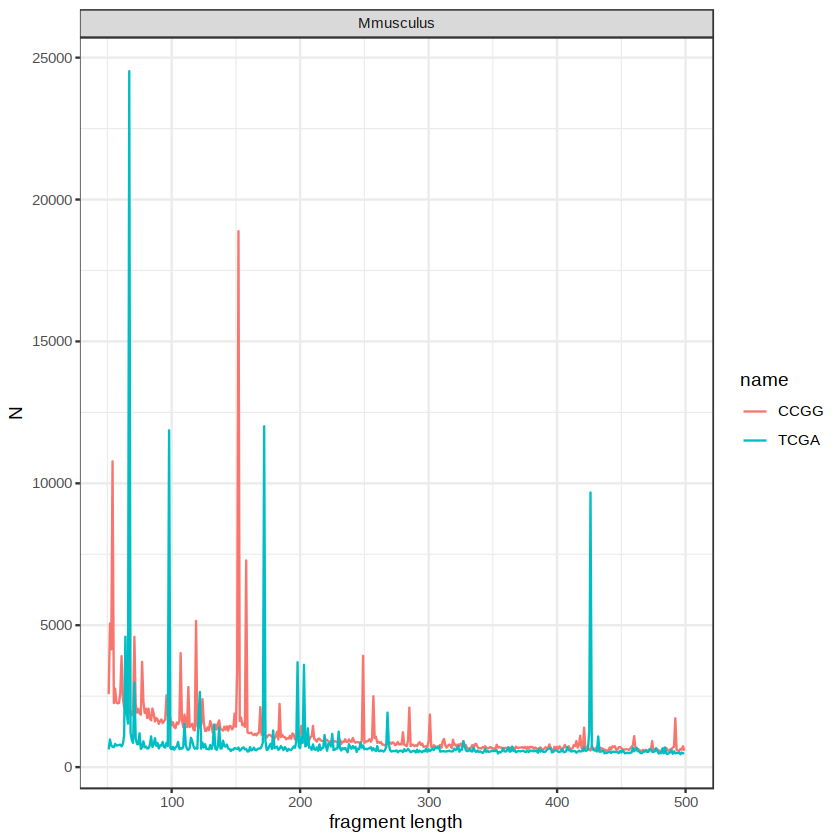

In [17]:
count=mdf[,.N,by=c("width","genome", "name")]
ggplot(count[width>50&width<500],aes(x=width,y=N, color = name))+geom_line()+facet_wrap(~genome,scale="free_y")+xlab("fragment length") + theme_bw()

In [10]:
head(unF)

genome,pattern,chr,start,end,width,origin,seq,dupl
Mmusculus,CCGG,chr1,-2,47,3003896,front,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,FALSE
Mmusculus,CCGG,chr1,3003898,3003947,3528,front,ATGTCTGGAGCCTGAAACAGGGGTATGTCCCAGACACTGTGTAGCTTCTG,FALSE
Mmusculus,CCGG,chr1,3007430,3007479,7177,front,AGTTGAGTGTAACTTTTTCCATCAGTTTTAATACATTAAGCAGCTTATCT,FALSE
Mmusculus,CCGG,chr1,3014611,3014660,359,front,AGACAGCATTAAGGAAGCAGAAAACCAGCCTGACCAGGGTCACAAGTCCC,FALSE
Mmusculus,CCGG,chr1,3014974,3015023,707,front,GGTACTAGTTAGTTCATATTGTTATTCCACCTATAGGGTTGCAGTTCCCA,FALSE
Mmusculus,CCGG,chr1,3015685,3015734,932,front,TTGGGACATCTTCTGGATATATGCAAAGGAGAGGTATTGTGGGATCCTTA,FALSE


In [11]:
head(mdf)

genome,chr,start,end,width,name
Mmusculus,chr1,0,3003899,3003902,CCGG
Mmusculus,chr1,3003898,3007431,3534,CCGG
Mmusculus,chr1,3007430,3014612,7183,CCGG
Mmusculus,chr1,3014611,3014975,365,CCGG
Mmusculus,chr1,3014974,3015686,713,CCGG
Mmusculus,chr1,3015685,3016622,938,CCGG


In [24]:
m <- matchPattern("CCGG", get("Mmusculus")[[1]])

In [48]:
CpGs <- matchPattern("CG", genome)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘matchPattern’ for signature ‘"BSgenome"’


In [47]:
head(CpGs)

  Views on a 195471971-letter DNAString subject
subject: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
views:
      start     end width
[1] 3000827 3000828     2 [CG]
[2] 3001007 3001008     2 [CG]
[3] 3001018 3001019     2 [CG]
[4] 3001277 3001278     2 [CG]
[5] 3001629 3001630     2 [CG]
[6] 3003226 3003227     2 [CG]

In [ ]:
### reading the actual RRBS data

In [ ]:
coveredPos <- 

In [ ]:
## re

In [50]:
?findOverlaps

findOverlaps-methods {SummarizedExperiment},R Documentation
"query, subject",One of these two arguments must be a RangedSummarizedExperiment object.
"maxgap, minoverlap, type",See ?findOverlaps in the GenomicRanges package.
"select, ignore.strand",See ?findOverlaps in the GenomicRanges package.
